# Airbnb Seattle Data Analysis

This is the first project of the [Udacity Data Scientist Nanodegree Program](https://www.udacity.com/course/data-scientist-nanodegree--nd025).

## Description
In this project, you will choose a dataset, identify three questions,<br>
and analyze the data to find answers to these questions. You will<br>
create a GitHub repository with your project, and write a blog post<br>
to communicate your findings to the appropriate audience. This<br>
project will help you reinforce and extend your knowledge of<br>
machine learning, data visualization, and communication.


The datasets used for this analysis are available on [Kaggle](https://www.kaggle.com/airbnb/seattle).

## Content

1. Read the data
2. Understand the data
3. Derive business questions or real-world use cases<br>
Q1: Is there an upward trend of new Airbnb listings in Seattle?<br>
Q2: What are the busiest times of the year to visit Seattle and how do prices change?<br>
Q1: Is there an upward trend of new Airbnb listings in Seattle?
Q3: Can we estimate the price for a common type of accommodation to see how much we should plan to spend?

## Import libraries and set options

In [1]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

In [2]:
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 100)

plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams["font.size"] = 12

sns.set_style("darkgrid")

sns_blue = "#1f77b4"
sns_orange = "#ff7f0e"

## Centralize utility functions

In [3]:
def clean_monetary_column(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Converts monetary string column with $ symbol into a float column.
    
    :param df: source dataframe
    :param col: column to convert
    :return: dataframe with converted column
    """
    df[col] = df[col].str.replace("$", "", regex=False)
    df[col] = df[col].str.replace(",", "", regex=False)
    df[col] = df[col].astype(float)
    return df

In [4]:
def create_dummy_df(df: pd.DataFrame, cat_cols: list, dummy_na: bool) -> pd.DataFrame:
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for cat_col in cat_cols:
        df_cat = pd.get_dummies(df[cat_col], prefix=cat_col, prefix_sep="_", drop_first=True, dummy_na=dummy_na)
        df = pd.concat([df, df_cat], axis=1)
    df = df.drop(columns=cat_cols)
    
    return df

## 1. Read the data

In [5]:
df_calendar = pd.read_csv("data/calendar.csv")

In [6]:
df_listings = pd.read_csv("data/listings.csv")

In [7]:
df_reviews = pd.read_csv("data/reviews.csv")

## 2. Understand the data

In [8]:
df_calendar.shape

(1393570, 4)

In [9]:
df_calendar.sample(5, random_state=42)

,listing_id,date,available,price
226311,8666707,2016-01-15,f,NaN
750902,3604931,2016-04-10,t,$495.00
972143,7177194,2016-05-31,t,$245.00
1280067,8863714,2016-01-16,t,$105.00
1154107,6248083,2016-12-11,t,$498.00


In [10]:
df_listings.shape

(3818, 92)

In [11]:
df_listings.sample(5, random_state=42)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
2562,8505940,https://www.airbnb.com/rooms/8505940,20160104002432,2016-01-04,Cozy room near UW,This 1918 house in the Montlake district is lo...,This beautiful 1918 home in the Montlake distr...,This 1918 house in the Montlake district is lo...,none,Montlake is a fashionable residential neighbor...,"If you have a car, please remember that city s...","Two frequent bus lines, #43 and #48, pass in f...",https://a2.muscache.com/ac/pictures/108111983/...,https://a2.muscache.com/im/pictures/108111983/...,https://a2.muscache.com/ac/pictures/108111983/...,https://a2.muscache.com/ac/pictures/108111983/...,30804330,https://www.airbnb.com/users/show/30804330,David,2015-04-07,"Seattle, Washington, United States","Been in the computer field most of my life, mo...",within an hour,100%,100%,f,https://a2.muscache.com/ac/users/30804330/prof...,https://a2.muscache.com/ac/users/30804330/prof...,Montlake,2.0,2.0,"['email', 'phone', 'reviews', 'jumio']",t,t,"24th Avenue East, Seattle, WA 98112, United St...",Montlake,Montlake,Capitol Hill,Seattle,WA,98112,Seattle,"Seattle, WA",US,United States,47.636394,-122.302401,t,House,Private room,2,0.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",NaN,$55.00,NaN,NaN,NaN,$15.00,1,$0.00,2,1125,5 days ago,t,22,43,73,151,2016-01-04,14,2015-09-27,2015-12-13,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.20
1425,5270886,https://www.airbnb.com/rooms/5270886,20160104002432,2016-01-04,"Walk To Space Needle, Pike Place S7",Experience Seattle's ultimate urban condo livi...,NaN,Experience Seattle's ultimate urban condo livi...,none,Close to everything including: * The Space Ne...,NaN,NaN,NaN,NaN,https://a0.muscache.com/ac/pictures/65861014/2...,NaN,4411144,https://www.airbnb.com/users/show/4411144,Emma,2012-12-15,"Seattle, Washington, United States",My husband and I are travel junkies! We love B...,within a day,63%,100%,f,https://a2.muscache.com/ac/users/4411144/profi...,https://a2.muscache.com/ac/users/4411144/profi...,Belltown,9.0,9.0,"['email', 'phone', 'linkedin', 'reviews', 'kba']",t,t,"4th Avenue, Seattle, WA 98121, United States",Belltown,Belltown,Downtown,Seattle,WA,98121,Seattle,"Seattle, WA",US,United States,47.615152,-122.342230,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",NaN,$82.00,NaN,NaN,NaN,$75.00,1,$0.00,1,1125,today,t,24,52,82,349,2016-01-04,11,2015-06-04,2015-11-10,98.0,10.0,10.0,9.0,10.0,10.0,9.0,f,NaN,WASHINGTON,f,strict,f,t,3,1.53
2186,1672979,https://www.airbnb.com/rooms/1672979,20160104002432,2016-01-04,Comfy Home Near Seward

In [12]:
df_reviews.shape

(84849, 6)

In [13]:
df_reviews.sample(5, random_state=42)

,listing_id,id,date,reviewer_id,reviewer_name,comments
41188,6637899,40956769,2015-08-03,5529156,Maggie,"Eileen was totally welcoming, a lovely host, o..."
51646,5918259,47360403,2015-09-18,3381323,Melissa,My hubby and I had a wonderful time at Dee's a...
70622,5405643,57282362,2015-12-24,3422670,Laura,Camille was absolutely amazing! Right after we...
17967,67270,1287853,2012-05-15,2335050,Jason,My girlfriend and I were coming into the city ...
2544,6780615,43287092,2015-08-18,39631367,Autie,Thanks for the great apartment. We had an awe...


## 3. Derive business questions or real-world use cases

- Q1: Is there an upward trend of new Airbnb listings in Seattle?
- Q2: What are the busiest times of the year to visit Seattle and how do prices vary?
- Q3: Can we estimate the price for a common type of accommodation to see how much we should plan to spend?

## Q1: Is there an upward trend of new Airbnb listings in Seattle?

For this question, the data from `df_listings` will be useful.

### Q1.1 Understand the data

In [14]:
df_listings.shape

(3818, 92)

In [15]:
df_listings.sample(5, random_state=42)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
2562,8505940,https://www.airbnb.com/rooms/8505940,20160104002432,2016-01-04,Cozy room near UW,This 1918 house in the Montlake district is lo...,This beautiful 1918 home in the Montlake distr...,This 1918 house in the Montlake district is lo...,none,Montlake is a fashionable residential neighbor...,"If you have a car, please remember that city s...","Two frequent bus lines, #43 and #48, pass in f...",https://a2.muscache.com/ac/pictures/108111983/...,https://a2.muscache.com/im/pictures/108111983/...,https://a2.muscache.com/ac/pictures/108111983/...,https://a2.muscache.com/ac/pictures/108111983/...,30804330,https://www.airbnb.com/users/show/30804330,David,2015-04-07,"Seattle, Washington, United States","Been in the computer field most of my life, mo...",within an hour,100%,100%,f,https://a2.muscache.com/ac/users/30804330/prof...,https://a2.muscache.com/ac/users/30804330/prof...,Montlake,2.0,2.0,"['email', 'phone', 'reviews', 'jumio']",t,t,"24th Avenue East, Seattle, WA 98112, United St...",Montlake,Montlake,Capitol Hill,Seattle,WA,98112,Seattle,"Seattle, WA",US,United States,47.636394,-122.302401,t,House,Private room,2,0.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",NaN,$55.00,NaN,NaN,NaN,$15.00,1,$0.00,2,1125,5 days ago,t,22,43,73,151,2016-01-04,14,2015-09-27,2015-12-13,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.20
1425,5270886,https://www.airbnb.com/rooms/5270886,20160104002432,2016-01-04,"Walk To Space Needle, Pike Place S7",Experience Seattle's ultimate urban condo livi...,NaN,Experience Seattle's ultimate urban condo livi...,none,Close to everything including: * The Space Ne...,NaN,NaN,NaN,NaN,https://a0.muscache.com/ac/pictures/65861014/2...,NaN,4411144,https://www.airbnb.com/users/show/4411144,Emma,2012-12-15,"Seattle, Washington, United States",My husband and I are travel junkies! We love B...,within a day,63%,100%,f,https://a2.muscache.com/ac/users/4411144/profi...,https://a2.muscache.com/ac/users/4411144/profi...,Belltown,9.0,9.0,"['email', 'phone', 'linkedin', 'reviews', 'kba']",t,t,"4th Avenue, Seattle, WA 98121, United States",Belltown,Belltown,Downtown,Seattle,WA,98121,Seattle,"Seattle, WA",US,United States,47.615152,-122.342230,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",NaN,$82.00,NaN,NaN,NaN,$75.00,1,$0.00,1,1125,today,t,24,52,82,349,2016-01-04,11,2015-06-04,2015-11-10,98.0,10.0,10.0,9.0,10.0,10.0,9.0,f,NaN,WASHINGTON,f,strict,f,t,3,1.53
2186,1672979,https://www.airbnb.com/rooms/1672979,20160104002432,2016-01-04,Comfy Home Near Seward

In [16]:
df_listings["id"].duplicated().sum()

0

### Q1.2 Check for missing values

In [17]:
df_listings["host_since"].isna().sum()

2

Insights:

- There are only 2 NaNs in host_since in all 3,818 listings.
- There is no need to clean these NaNs since they will be dropped anyways when the data gets aggregated.

### Q1.3 Preprocess the data

In [18]:
df_listings["host_since"] = pd.to_datetime(df_listings["host_since"], format="%Y-%m-%d")
df_listings["host_since"] = df_listings["host_since"].dt.isocalendar().year

### Q1.4 Aggregate the data

In [19]:
df_new_listings = (
    df_listings
    .groupby(["host_since"], as_index=False)
    .agg(num_listings=("id", "count"))
)

### Q1.5 Visualize the data

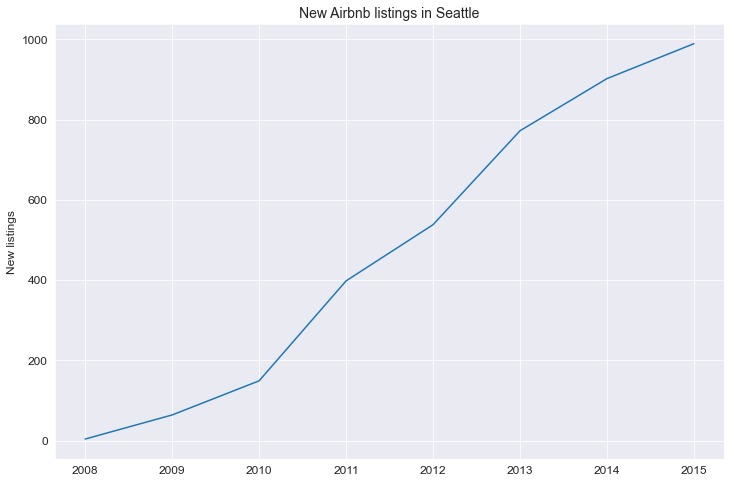

In [20]:
fix, ax = plt.subplots()
sns.lineplot(data=df_new_listings, x="host_since", y="num_listings")
ax.set_title("New Airbnb listings in Seattle")
ax.set_xlabel(None), ax.set_ylabel("New listings");

In [21]:
df_new_listings

,host_since,num_listings
0,2008,4
1,2009,64
2,2010,149
3,2011,398
4,2012,538
5,2013,772
6,2014,902
7,2015,989


## Q2: What are the busiest times of the year to visit Seattle and how do prices change?

For this question, the data from `df_calendar` will be useful.

### Q2.1 Understand the data

In [22]:
df_calendar.shape

(1393570, 4)

In [23]:
df_calendar.sample(5, random_state=42)

,listing_id,date,available,price
226311,8666707,2016-01-15,f,NaN
750902,3604931,2016-04-10,t,$495.00
972143,7177194,2016-05-31,t,$245.00
1280067,8863714,2016-01-16,t,$105.00
1154107,6248083,2016-12-11,t,$498.00


### Q2.2 Check for missing values

In [24]:
df_calendar.notna().sum()

listing_id    1393570
date          1393570
available     1393570
price          934542
dtype: int64

In [25]:
df_calendar.groupby(["available"])["price"].count()

available
f         0
t    934542
Name: price, dtype: int64

Insights:
- To make the price a float, the $ symbol needs to be removed.
- There are NaNs in price but all NaNs are from unavailable listings.

### Q2.3 Preprocess the data

In [26]:
df_calendar = clean_monetary_column(df_calendar, col="price")

In [27]:
df_calendar["date"] = pd.to_datetime(df_calendar["date"], format="%Y-%m-%d")
df_calendar["month"] = df_calendar["date"].dt.month
df_calendar["month_name"] = df_calendar["date"].dt.month_name()
df_calendar["week"] = df_calendar["date"].dt.isocalendar().week

In [28]:
df_calendar.sample(random_state=42)

,listing_id,date,available,price,month,month_name,week
226311,8666707,2016-01-15,f,NaN,1,January,2


### Q2.4 Aggregate the data

In [29]:
df_available = df_calendar[df_calendar["available"] == "t"]

In [30]:
df_month = (
    df_available
    .groupby(["month", "month_name"], as_index=False)
    .agg(num_available=("listing_id", "count"))
)

In [31]:
df_month["num_available_vs_mean"] = df_month["num_available"] / df_month["num_available"].mean()

In [32]:
df_price = (
    df_available
    .groupby(["month", "month_name"], as_index=False)
    .agg(average_price=("price", "mean"))
)

### Q2.5 Visualize the data

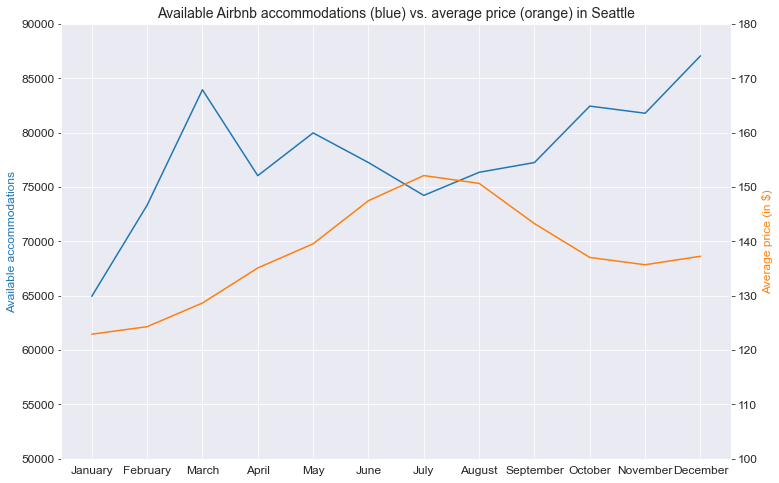

In [33]:
sns.set_style("darkgrid")
fix, ax1 = plt.subplots()
ax1.set_title("Available Airbnb accommodations (blue) vs. average price (orange) in Seattle")

sns.lineplot(data=df_month, x="month_name", y="num_available", color=sns_blue)
ax1.set_xlabel(None)
ax1.set_ylabel("Available accommodations", color=sns_blue)
ax1.set_ylim(50000,90000);

ax2 = ax1.twinx()

sns.lineplot(data=df_price, x="month_name", y="average_price", color=sns_orange)
ax2.set_xlabel(None)
ax2.set_ylabel("Average price (in $)", color=sns_orange)
ax2.set_ylim(100,180)
ax2.grid(None);

In [34]:
df_month

,month,month_name,num_available,num_available_vs_mean
0,1,January,64937,0.833824
1,2,February,73321,0.941479
2,3,March,83938,1.077807
3,4,April,76037,0.976354
4,5,May,79971,1.026869
5,6,June,77244,0.991853
6,7,July,74222,0.953049
7,8,August,76347,0.980335
8,9,September,77246,0.991878
9,10,October,82438,1.058546


## Q3: Can we estimate the price for a common type of accommodation to see how much we should plan to spend?

For this question, the data from `df_listings` will be useful.

### Q3.1 Understand the data

In [35]:
df_listings.sample(5, random_state=42)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
2562,8505940,https://www.airbnb.com/rooms/8505940,20160104002432,2016-01-04,Cozy room near UW,This 1918 house in the Montlake district is lo...,This beautiful 1918 home in the Montlake distr...,This 1918 house in the Montlake district is lo...,none,Montlake is a fashionable residential neighbor...,"If you have a car, please remember that city s...","Two frequent bus lines, #43 and #48, pass in f...",https://a2.muscache.com/ac/pictures/108111983/...,https://a2.muscache.com/im/pictures/108111983/...,https://a2.muscache.com/ac/pictures/108111983/...,https://a2.muscache.com/ac/pictures/108111983/...,30804330,https://www.airbnb.com/users/show/30804330,David,2015,"Seattle, Washington, United States","Been in the computer field most of my life, mo...",within an hour,100%,100%,f,https://a2.muscache.com/ac/users/30804330/prof...,https://a2.muscache.com/ac/users/30804330/prof...,Montlake,2.0,2.0,"['email', 'phone', 'reviews', 'jumio']",t,t,"24th Avenue East, Seattle, WA 98112, United St...",Montlake,Montlake,Capitol Hill,Seattle,WA,98112,Seattle,"Seattle, WA",US,United States,47.636394,-122.302401,t,House,Private room,2,0.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",NaN,$55.00,NaN,NaN,NaN,$15.00,1,$0.00,2,1125,5 days ago,t,22,43,73,151,2016-01-04,14,2015-09-27,2015-12-13,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.20
1425,5270886,https://www.airbnb.com/rooms/5270886,20160104002432,2016-01-04,"Walk To Space Needle, Pike Place S7",Experience Seattle's ultimate urban condo livi...,NaN,Experience Seattle's ultimate urban condo livi...,none,Close to everything including: * The Space Ne...,NaN,NaN,NaN,NaN,https://a0.muscache.com/ac/pictures/65861014/2...,NaN,4411144,https://www.airbnb.com/users/show/4411144,Emma,2012,"Seattle, Washington, United States",My husband and I are travel junkies! We love B...,within a day,63%,100%,f,https://a2.muscache.com/ac/users/4411144/profi...,https://a2.muscache.com/ac/users/4411144/profi...,Belltown,9.0,9.0,"['email', 'phone', 'linkedin', 'reviews', 'kba']",t,t,"4th Avenue, Seattle, WA 98121, United States",Belltown,Belltown,Downtown,Seattle,WA,98121,Seattle,"Seattle, WA",US,United States,47.615152,-122.342230,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",NaN,$82.00,NaN,NaN,NaN,$75.00,1,$0.00,1,1125,today,t,24,52,82,349,2016-01-04,11,2015-06-04,2015-11-10,98.0,10.0,10.0,9.0,10.0,10.0,9.0,f,NaN,WASHINGTON,f,strict,f,t,3,1.53
2186,1672979,https://www.airbnb.com/rooms/1672979,20160104002432,2016-01-04,Comfy Home Near Seward Park Seattl

#### Extract useful columns
 
By simply going through the data column by column and doing a first check with respect to value counts, the dependent variable `price` and a set of independent variables which could be useful for predicting the price of an accommodation was created. Please note that the remaining columns could be useful to improve predictions. For now, the focus is on building a solid but not perfect model.

In [36]:
dependent = ["price"]
independent = [
    "neighbourhood_group_cleansed",
    "property_type",
    "room_type",
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    "bed_type",
    "cleaning_fee",
]

### Q3.2 Check for missing values

In [37]:
df_listings[dependent].isna().mean()

price    0.0
dtype: float64

In [38]:
df_listings[independent].isna().mean().sort_values()

neighbourhood_group_cleansed    0.000000
room_type                       0.000000
accommodates                    0.000000
bed_type                        0.000000
property_type                   0.000262
beds                            0.000262
bedrooms                        0.001572
bathrooms                       0.004191
cleaning_fee                    0.269775
dtype: float64

Insights:
- There are no NaNs in the independent variable and thus no need to drop entire rows.
- There are NaNs in some dependent variables.
- There are no columns with almost only NaNs and thus the NaNs will be imputed for all columns.

In [39]:
df_model = df_listings.copy()
df_model = df_model[dependent + independent]

### Q3.3 Check for correlations

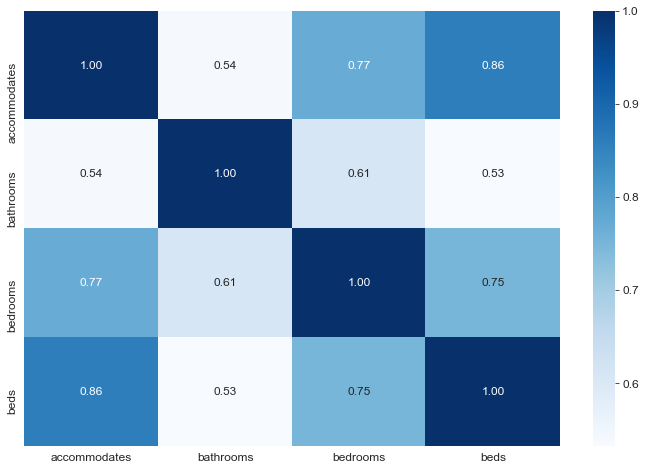

In [40]:
sns.heatmap(df_model.corr(), annot=True, fmt=".2f", cmap=plt.get_cmap("Blues"));

### Q3.4 Preprocess the data

#### Clean data types

In [41]:
for col in ["price", "cleaning_fee"]:
    df_model = clean_monetary_column(df_model, col=col)

#### Handle NaNs

- Fill NaNs with mean for independent numerical variables

In [42]:
independent_numerical = list(df_model[independent].select_dtypes(include=("int", "float", "Int64")).columns)

In [43]:
fill_mean = lambda x: x.fillna(x.mean())

In [44]:
df_model[independent_numerical] = df_model[independent_numerical].apply(fill_mean)

- Create dummy variables for independent categorical variables (keep an extra dummy column for NaNs)

In [45]:
independent_categorical = list(df_model[independent].select_dtypes(include=("object")).columns)

In [46]:
df_model = create_dummy_df(df_model, cat_cols=independent_categorical, dummy_na=True)

### Q3.5 Model

#### Split into training and test data

In [47]:
X = df_model.drop(columns=dependent)
y = df_model[dependent]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Instantiate, fit, predict & score

In [48]:
lm_model = LinearRegression(normalize=True)

In [49]:
lm_model.fit(X_train, y_train);

In [50]:
y_test_pred = lm_model.predict(X_test)
y_train_pred = lm_model.predict(X_train)

In [51]:
test_score = r2_score(y_test, y_test_pred)
train_score = r2_score(y_train, y_train_pred)

In [52]:
print(f"By training the model with {len(X_train)} training examples, the model achieved an R squared of {round(train_score,4)} on the training set and {round(test_score,4)} on the test set.")

By training the model with 3054 training examples, the model achieved an R squared of 0.5859 on the training set and 0.5976 on the test set.


### Q3.6 Visualize the data

In [53]:
df_feature_importance = pd.DataFrame()
df_feature_importance["feature"] = X_train.columns
df_feature_importance["coefficient"] = lm_model.coef_[0]
df_feature_importance["abs_coefficient"] = np.abs(lm_model.coef_[0])

In [54]:
df_feature_importance = df_feature_importance.sort_values(by="abs_coefficient", ascending=False)

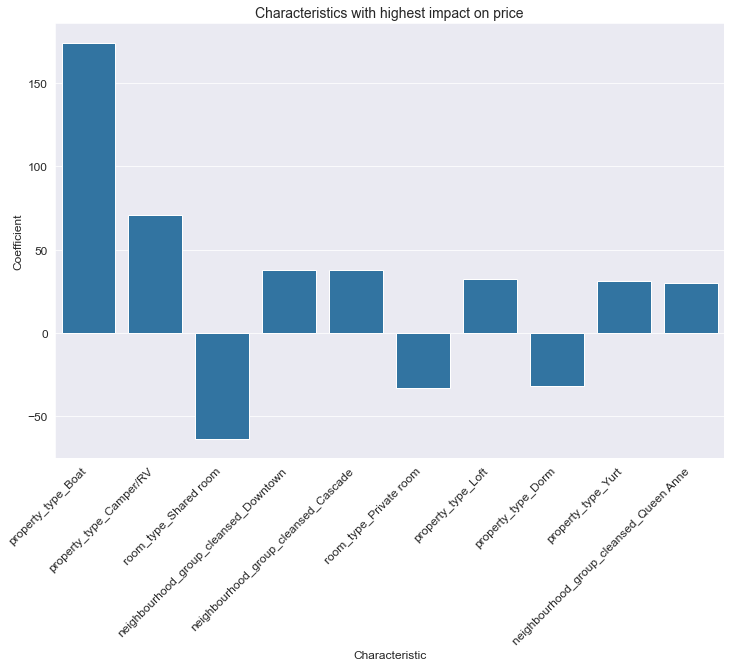

In [55]:
fig, ax = plt.subplots()
sns.barplot(data=df_feature_importance[:10], x="feature", y="coefficient", color=sns_blue)
ax.set_title("Characteristics with highest impact on price")
ax.set_xlabel("Characteristic"), ax.set_ylabel("Coefficient")
ax.set_xticklabels(labels=df_feature_importance[:10].feature, rotation=45, ha="right");

In [56]:
df_feature_importance_numerical = df_feature_importance[df_feature_importance["feature"].isin(independent_numerical)].sort_values(by="abs_coefficient", ascending=False)

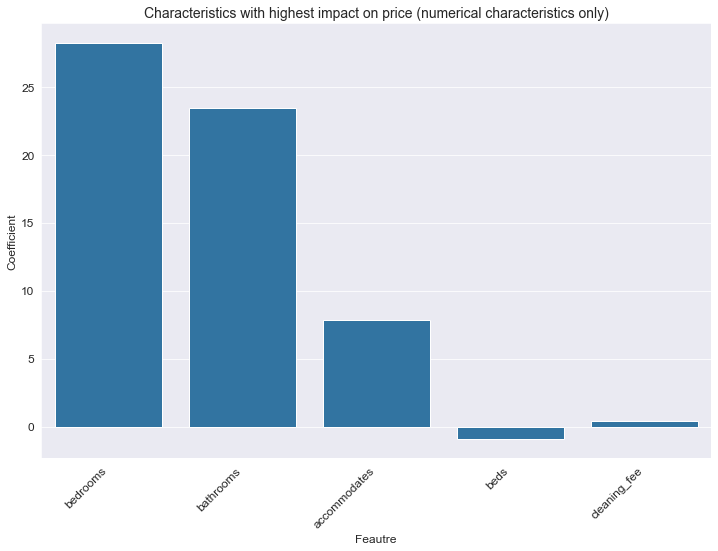

In [57]:
fig, ax = plt.subplots()
sns.barplot(data=df_feature_importance_numerical, x="feature", y="coefficient", color=sns_blue)
ax.set_title("Characteristics with highest impact on price (numerical characteristics only)")
ax.set_xlabel("Feautre"), ax.set_ylabel("Coefficient")
ax.set_xticklabels(labels=df_feature_importance_numerical.feature, rotation=45, ha="right");

Insights:

- The model was trained on 2,672 data points
- The R squared on the training and test set is ~0.586 on the training set and ~0.593 on the test set.
- The model is able to explain ~60% of the variability in the price.
- The model is not overfitted.
- Categorical features have the highest coefficients in this model.
- Renting a boat makes the price much higher. 
- In contrast, the property types shared room, private room and dorm have the effect of making the price decrease.

### Q3.7 Predict price for a common type of accommodation

When browsing for Airbnb accommodations in Seattle, the following part can be helpful to make the model predict a price based on a custom accommodation, as the example below shows.

In [58]:
# X_sample = X.sample()
# idx = X_sample.index[0]
# X_dict = X_sample.to_dict()
# X_dict = {i: 0 for i,v in X_dict.items()}

In [59]:
X_example = {
    'accommodates': 4,
    'bathrooms': 1,
    'bedrooms': 2,
    'beds': 4,
    'cleaning_fee': 30,
    'neighbourhood_group_cleansed_Beacon Hill': 0,
    'neighbourhood_group_cleansed_Capitol Hill': 0,
    'neighbourhood_group_cleansed_Cascade': 0,
    'neighbourhood_group_cleansed_Central Area': 0,
    'neighbourhood_group_cleansed_Delridge': 0,
    'neighbourhood_group_cleansed_Downtown': 1,
    'neighbourhood_group_cleansed_Interbay': 0,
    'neighbourhood_group_cleansed_Lake City': 0,
    'neighbourhood_group_cleansed_Magnolia': 0,
    'neighbourhood_group_cleansed_Northgate': 0,
    'neighbourhood_group_cleansed_Other neighborhoods': 0,
    'neighbourhood_group_cleansed_Queen Anne': 0,
    'neighbourhood_group_cleansed_Rainier Valley': 0,
    'neighbourhood_group_cleansed_Seward Park': 0,
    'neighbourhood_group_cleansed_University District': 0,
    'neighbourhood_group_cleansed_West Seattle': 0,
    'neighbourhood_group_cleansed_nan': 0,
    'property_type_Bed & Breakfast': 0,
    'property_type_Boat': 0,
    'property_type_Bungalow': 0,
    'property_type_Cabin': 0,
    'property_type_Camper/RV': 0,
    'property_type_Chalet': 0,
    'property_type_Condominium': 0,
    'property_type_Dorm': 0,
    'property_type_House': 0,
    'property_type_Loft': 1,
    'property_type_Other': 0,
    'property_type_Tent': 0,
    'property_type_Townhouse': 0,
    'property_type_Treehouse': 0,
    'property_type_Yurt': 0,
    'property_type_nan': 0,
    'room_type_Private room': 1,
    'room_type_Shared room': 0,
    'room_type_nan': 0,
    'bed_type_Couch': 0,
    'bed_type_Futon': 0,
    'bed_type_Pull-out Sofa': 0,
    'bed_type_Real Bed': 1,
    'bed_type_nan': 0
}

In [60]:
lm_model.predict(pd.DataFrame([X_example]))

array([[165.51657078]])

Insights:
- For a private loft in Seattle Downtown with the following characteristics:
    - 2 bedrooms,
    - 4 beds,
    - 1 bathroom and
    - \$30 cleaning fee,
- this model predicts about 165$ per night.
    
This insight could be used to get a rough understanding about whether an apartment tends to be overpriced or underpriced.
 
Please keep in mind the following:
- As shown above, the prices vary during the year.
- The prediction model explains only 60% of the variability in the price which there are still plenty of factors which are not considered here.